# Natural language processing

Natural language processing (NLP) is a machine learning technique to do analyze large amounts of text to extract information. Some examples are sentiment analysis, translation, transcription, summarizing, tagging, but NLP is a very broad term and can apply to anything text related.

It's also a very hard task for computers because language is a very ill-defined thing. For example,
* Verbs can sometimes be nouns (make, set)
* Words that are spelled the same can have different meanings (spot=stain/availability, fall=season/drop).
* Idoms (hot potato, piece of cake)

Try explaining all of that to a computer! Yet, depending on the goal, that is exactly what we need to do with NLP.

Comment: explain in this notebook we are going to condcut analysis on the data taken from Yelp and do 
...

## Learning objectives

Average time to complete: 30min

By the end of this tutorial you should be able to:

* Visualize parts of the data and interpret the results of word clouds
* Describe what the Sentiment Analysis is and how we use it
* Use the default model

## What you will need for this tutorial

* See the [introduction document](https://uottawa-it-research-teaching.github.io/machinelearning/) for general requirements and how Jupyter notebooks work.
* We'll need Pandas for convenient data handling. It's a very powerful Python package that can read CSV and Excel files. It also has very good data manipulation capabilities which come in use for data cleaning.
* We will use NLTK as our machine learning package. NLTK stands for Natural Language Tool Kit.
* The data files that you will need to download from Yelp yourself

One other package that you need is "wordcloud" which we will use later to create word clouds. This is not a package that is usually installed by default, so you will need to install it manually. How to do so, depends on your Python environment. If you use Anaconda or Miniconda, it would be:

    conda install wordcloud

For most other Python environments, it would be:

    pip install wordcloud

In [1]:
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer, SentimentIntensityAnalyzer
from nltk.sentiment.util import *
import json
import wordcloud
import matplotlib.pyplot as plt
import pandas as pd

## Sentiment analysis
When studying a controversial topic, often people have opinions. From online discourse, you can glean a lot of information, but it requires reading every post to see if people feel positive or negative about it. NLP can help with this. Using the Natural Language Toolkit (NLTK), you will be able to do sentiment analysis.

Sentiment analysis works by creating frequency distributions that correspond to positive texts and distributions that correspond negative text. Then using those distributions, it it able to tell whether a new text is closer to one distribution than another and thus mark a text as positive or negative.

Yelp provides a free data set that has a big chunk of their business reviews with over 6 million reviews. This is an excellent dataset for sentiment analysis. It is however also really big, so you will have to download it yourself. It also has a specific Dataset licence you need to agree to which details what you are and are not allowed to do with it.

Download it here: https://www.yelp.com/dataset

**Note:** We extract the data to "/tmp/yelp" but you will likely have a different path. Adjust any `open` statement below to point to wherever you have the json files.

The dataset is made up of multiple files. Busines details and reviews are in different files. The records in those files are all linked with ID numbers though.

The format of the data is in JSONL format which is just a text file with lots of JSON records with one JSON record on each line. JSON in turn is a markup language that is great at representing unstructured data in a textual format. Python has the JSON library to deal with that, lets read the first business. Busines information is stored in "yelp_academic_dataset_business.json".

In [2]:
with open('/tmp/yelp/yelp_academic_dataset_business.json') as f:
    for line in f:
        business = json.loads(line)
        print(business)
        break # This break statement breaks out of the for loop so only the first line of the JSONL file is read

{'business_id': 'Pns2l4eNsfO8kk83dixA6A', 'name': 'Abby Rappoport, LAC, CMQ', 'address': '1616 Chapala St, Ste 2', 'city': 'Santa Barbara', 'state': 'CA', 'postal_code': '93101', 'latitude': 34.4266787, 'longitude': -119.7111968, 'stars': 5.0, 'review_count': 7, 'is_open': 0, 'attributes': {'ByAppointmentOnly': 'True'}, 'categories': 'Doctors, Traditional Chinese Medicine, Naturopathic/Holistic, Acupuncture, Health & Medical, Nutritionists', 'hours': None}


The JSON library converted the data into a Python dictionary. You can see the various fields like "business_id", "name", "address" and so on. We want to use the "business_id" next, so we store that in the variable called `business`.

So our first business is Abby Rappoport. Let's find the reviews that go with that business and store that in the list called "yelp_academic_dataset_review.json". That file contains 6 milion reviews from all sorts of businesses. We need to get just the ones from Abby, but to do that we still need to parse the entire file, so this will take a few minutes.

The reviews are stored using the "business_id" that we saw when reading "yelp_academic_dataset_business.json". So we need to use that ID and compare it to the one used in the reviews to filter out those reviews.

In [3]:
reviews = []
with open('/tmp/yelp/yelp_academic_dataset_review.json') as f:
    for line in f:
        review = json.loads(line)
        if review['business_id'] == business['business_id']:
            reviews.append(review)

How many reviews did we get?

In [4]:
len(reviews)

7

So we have 7 reviews. Let's see what they say.

In [5]:
reviews

[{'review_id': '9vwYDBVI3ymdqcyJ5WW2Tg',
  'user_id': 'e0imecnX_9MtLnS2rUZM-A',
  'business_id': 'Pns2l4eNsfO8kk83dixA6A',
  'stars': 5.0,
  'useful': 3,
  'funny': 2,
  'cool': 1,
  'text': "I've had acupuncture treatments with Abby over the past few years and I really can't say enough about how great my experiences have been.\n\nShe has successfully treated me for everything from stress to colds to menstrual cramps.  I was amazed that her medical qi gong treatments helped alleviate my chronic back pain.  I didn't think anything could help with that!  \n\nShe is always very clear and upfront about treatments and expectations.   And I love that she always has great advice on herbs, supplements and natural remedies.\n\nShe just relocated to Los Gatos and I'm definitely going to miss having her in San Francisco!",
  'date': '2012-05-02 18:07:38'},
 {'review_id': 'OXgg1LdxHDv3CBU5-xi2lA',
  'user_id': '_Q0fdLVoTnlNkEypUvNkHA',
  'business_id': 'Pns2l4eNsfO8kk83dixA6A',
  'stars': 5.0,
  '

One nice thing to visualize reviews (or other texts) is by creating a wordcloud.

For that, we first need to merge all of the reviews into one big text. The following code will take all the "text" entry in the array and join them with newlines.

In [6]:
reviewtext = "\n".join([review['text'] for review in reviews])

Then create the wordcloud using to the wordcloud package to plot it. It generates an image that we store in the variable `cloud`.

In [7]:
cloud = wordcloud.WordCloud(background_color='white').generate(reviewtext)

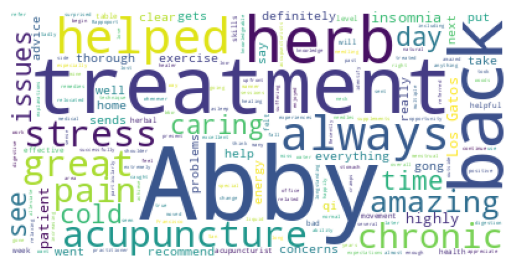

In [8]:
plt.axis('off')
plt.imshow(cloud)

That shows at a glance what this business is about. You can see that the name Abby features prominently of course, but you also see that this is a place that does acupuncutre and treatments and especially for back pain.

To see if a business is good or not, we can use the stars that people usually give with a review, but this is not always very accurate. People can be very positive in their review but still not give five stars or people can be a bit unhappy and straight go to one star. To get a better idea of a business, you'd generally read the actual reviews.

However, if you have lots of businesses and reviews, that will become very time consuming! So it's better to have a computer to do this. Of course, NLP is hard because language is such an ambiguous thing as mentioned earlier.

Enter machine learning! NLTK has a bunch of pretrained models. One of them is VADER which is good for short texts or sentences. The `SentimentIntensityAnalyzer` will use this model to analyze the reviews.

We first need to download it, but NLTK has a function for that.

In [9]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jvanderk/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

Then create the analyzer

In [10]:
sia = SentimentIntensityAnalyzer()

Let's see what it thinks of the first review

In [11]:
sia.polarity_scores(reviews[0]['text'])

{'neg': 0.061, 'neu': 0.699, 'pos': 0.24, 'compound': 0.9735}

The number to look for here is compound which combines that negativity, positivity, and neutrality in one easily understandable score that ranges from -1 (BAD!) to 1 (GREAT!).

So in this case, the first review is very close to 1. This must be a very positive review. Let's see what it was.

In [12]:
print(reviews[0]['text'])

I've had acupuncture treatments with Abby over the past few years and I really can't say enough about how great my experiences have been.

She has successfully treated me for everything from stress to colds to menstrual cramps.  I was amazed that her medical qi gong treatments helped alleviate my chronic back pain.  I didn't think anything could help with that!  

She is always very clear and upfront about treatments and expectations.   And I love that she always has great advice on herbs, supplements and natural remedies.

She just relocated to Los Gatos and I'm definitely going to miss having her in San Francisco!


And indeed, that was a very positive review. Let's look at all the reviews now.

In [13]:
for i, review in enumerate(reviews):
    print(i, ':', sia.polarity_scores(review['text'])['compound'])

0 : 0.9735
1 : 0.4304
2 : 0.9573
3 : 0.974
4 : 0.9079
5 : -0.5859
6 : 0.9391


There is one review with index 5 that is pretty negative. Let's see what that is about.

In [14]:
print(reviews[5]['text'])

Abby Rappoport helped me achieve a long lost sense of health. I was suffering from debilitating insomnia due to a very stressful job and family requirements. She also was able to get me through a bad bout of bronchitis. 
She is professional, thorough and clearly seasoned as a healthcare provider.
I highly recommend Abby if your situation needs caring attention.


So this was actually a positive review for Abby. However, the language itself is clearly very negative, "stress", "debilitating", "bad bout", etc. That shows that this model isn't always correct. It is however often good enough. Even in this case, based on all of the reviews, it would still classify Abby's business as a very positive experience which is accurate.

We can now combine the codes so far into one bigger code that will analyse the sentiments of multiple businesses. We'll read the first five and get the reviews for those.

In [15]:
businesses = {}
with open('/tmp/yelp/yelp_academic_dataset_business.json') as businessfile, open('/tmp/yelp/yelp_academic_dataset_review.json') as reviewfile:
    # Read the first businesses into a dictionary. The dictionary key is the ID of the business.
    for i, line in enumerate(businessfile):
        business = json.loads(line)
        businesses[business["business_id"]] = {
            "name": business["name"],
            "reviews": [],
            "sentiments": []
        }
        if i >= 4: # Get the first five
            break

    # Now go through all the reviews and pick the ones that have a business_id that matches any of the businsses we selected.
    for line in reviewfile:
        review = json.loads(line)
        for business_id in businesses.keys():
            if review['business_id'] == business_id:
                businesses[business_id]["reviews"].append(review['text'])
                businesses[business_id]["sentiments"].append(sia.polarity_scores(review['text']))

The variable `businesses` now contains five businesses with their names and all of the reviews and their sentiment analysis. Now we can see how positive people are about these businesses without relying on stars or anything.

In [16]:
for business in businesses.values():
    positive = 0
    total = 0
    for sentiment in business["sentiments"]:
        total += 1
        if sentiment["compound"] > 0:
            positive += 1
    print(f"{business['name']} scores {positive} out of {total}")

Abby Rappoport, LAC, CMQ scores 6 out of 7
The UPS Store scores 13 out of 15
Target scores 24 out of 24
St Honore Pastries scores 76 out of 87
Perkiomen Valley Brewery scores 12 out of 13


We could now do this for the entire dataset, but with so many businesses this is going to take a long time. If you are really interested, you can remove the `if >= 4` limit we have and just let it run for a few days!

## Conclusion

We have seen how the sentiment analysis can be used to quantify potentially huge amounts of text to get a sense if people are positive or negative about it using the built-in pre-trained models that come with NLTK.

You can also train your own models if the default ones are not good enough for your use case. That material goes beyond the scope of these notebooks how but a good tutorial on this can be found at https://realpython.com/python-nltk-sentiment-analysis/.